In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [2]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
        jobtitle_list.append(str(i.text.encode('utf8')))
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    for i in result.findAll('span', class_ = 'location'):
        location_list.append(str(i.text.encode('utf8')))
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    for i in result.findAll('span', class_ = 'company'):
        company = str(i.text.encode('utf8'))
        company = company.replace('\n', '')
        company = company.replace('    ', '')
        company_list.append(company)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    for i in result.findAll('td', class_ = 'snip'):
        if i.find('nobr') != None:
            salary_list.append(i.find('nobr').text)
        else:
            salary_list.append('NaN')
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    return pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 

In [3]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

max_results_per_city = 1000

##### Create empty dataframe with the columns we want; concatenate to it the new one generated for each city
df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

for city in set(['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', 'Phoenix,+AZ', \
'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', 'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA',\
'Indianapolis,+IN', 'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', 'El+Paso,+TX', \
'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', 'Nashville,+TN']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        x = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        x['city'] = nice_city
        x['state'] = state
        df = pd.concat([x, df], axis = 0)   

In [4]:
df['salary'] = df['salary'].apply(lambda x: str(x))
df['salary'] = df['salary'].apply(lambda x: str(x.replace('nan', 'NaN')))
df = df[['title', 'location', 'company', 'salary', 'city', 'state']]

In [5]:
df = df.reset_index(drop = True)

In [6]:
print 'Total number of listings: %s' %len(df) 
print 'Listings with non-\'NaN\' salary entries: %s' %len(df[df['salary'] != 'NaN'])
print 'Percentage with non-\'NaN\' salary entries: %s' %(float(len(df[df['salary'] != 'NaN']))/len(df))

Total number of listings: 17195
Listings with non-'NaN' salary entries: 562
Percentage with non-'NaN' salary entries: 0.0326839197441


In [7]:
print 'Of all salary entries:'
print '\n'
print '%s are per month;' %len(df[df['salary'].str.contains('month')]) 
print '%s are per week;' %len(df[df['salary'].str.contains('week')])
print '%s are per hour;' %len(df[df['salary'].str.contains('hour')])
print '%s are per day.' %len(df[df['salary'].str.contains('day')])
print '\n'
print 'Delete all of these.'

Of all salary entries:


66 are per month;
1 are per week;
203 are per hour;
3 are per day.


Delete all of these.


In [8]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [9]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' non-\'NaN\' salary entries, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as yearly.'

Of 289 non-'NaN' salary entries, 289 are explicitly labeled as yearly.


In [10]:
if (-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) != 0:
    print 'The %s' %(-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) +' which are not \
explicitly labeled as yearly salaries are the following:'
    print df[(df['salary'] != 'NaN') & (df['salary'].str.contains('year') == False)]
else:
    print '(None)'

(None)


In [11]:
def num_cat(x):
    '''This function returns a set containing all data types contained in the argument provided.'''
    cat_list = []
    for i in x:
        cat_list.append(type(i))
    return set(cat_list)

In [12]:
num_cat(df['salary'])

{str}

In [13]:
def parse_salary(df):
    '''This function takes a dataframe argument containing a column 'salary' and creates a new column, \
    'parsed_salary', with corresponding float entries (which are the average of a range, if and when provided).'''
    parsed_salary = []
    for i in df['salary']:
        if i == 'NaN':
            parsed_salary.append(i)
        elif i != 'NaN':
            x = str(i)
            if '-' in x:
                x = x.split('-')
                x[0] = x[0].replace('$', '')
                x[0] = x[0].replace(',', '')
                x[0] = x[0].replace(' ', '')
                x[1] = x[1].replace('$', '')
                x[1] = x[1].replace(',', '')
                x2 = x[1].split(' ')
                x[1] = x2[1]
                new_x = (float(x[0]) + float(x[1]))/2
                parsed_salary.append(new_x)   
            elif '$' in x:
                z = x.split(' ')
                z = z[0]
                z = z.replace('$', '')
                z = z.replace(',', '')
                parsed_salary.append(float(z))
            else:
                parsed_salary.append('delete_me')
    df['parsed_salary'] = parsed_salary
    df = df[df['parsed_salary'].str.contains('delete_me') == False]
    return 

In [14]:
parse_salary(df)

In [15]:
df[df['parsed_salary'] != 'NaN'].head()

,title,location,company,salary,city,state,parsed_salary
631,Associate Consultant- Biotech/Pharma Market Re...,"Boston, MA",Workbridge Associates,"$65,000 - $85,000 a year",Boston,MA,75000
646,Quantitative Data Analyst,"Boston, MA",The Bivium Group,"$80,000 - $130,000 a year",Boston,MA,105000
666,"Data Scientist, Machine Learning Engineer","Boston, MA",Princeton Consulting,"$140,000 - $220,000 a year",Boston,MA,180000
765,"Data Scientist, Machine Learning Engineer","Boston, MA",Execu | Search,"$110,000 - $150,000 a year",Boston,MA,130000
780,Data Analyst/Engineer,"Boston, MA",Smith Hanley Associates,"$145,000 - $160,000 a year",Boston,MA,152500


In [16]:
df.to_csv('IndeedSalaryData3.csv', encoding='utf-8')

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as st
import re
import sklearn
from sklearn import linear_model as lm
from sklearn import cross_validation, preprocessing
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import mean_squared_error

% matplotlib inline

In [18]:
df_new = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData3.csv')
df_new = df_new[['title', 'location', 'company', 'city', 'state', 'parsed_salary']]

In [19]:
#sal_df = df_new[df_new['parsed_salary'] != 'NaN']
sal_df = df_new[df_new['parsed_salary'] >= 0]
sal_df = sal_df.reset_index(drop = True)
print len(sal_df)
sal_df.head(1)

289


,title,location,company,city,state,parsed_salary
0,Associate Consultant- Biotech/Pharma Market Re...,"Boston, MA",Workbridge Associates,Boston,MA,75000.0


In [34]:
sal_df = sal_df[sal_df['company'] != 'Department of the Army']

In [40]:
sal_df = sal_df[sal_df['company'] != 'Jobspring Partners']

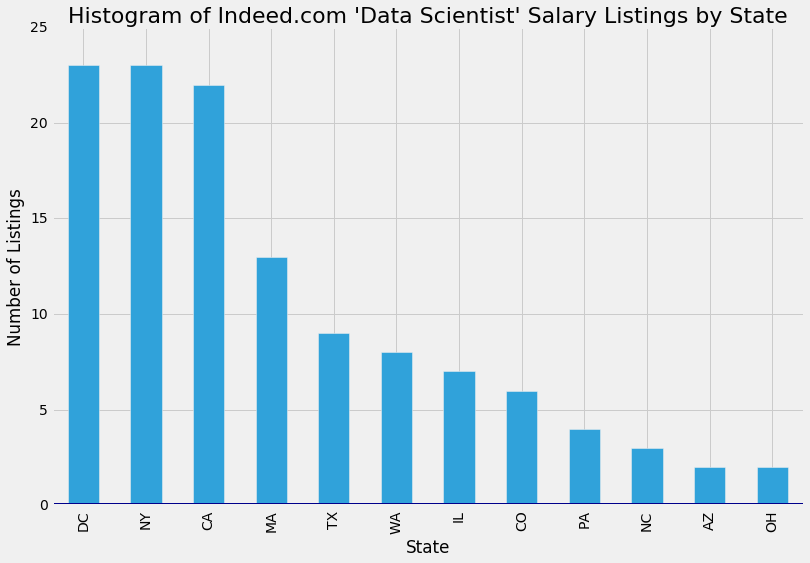

In [41]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

states = sal_df['state'].value_counts()

states.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Histogram of Indeed.com \'Data Scientist\' Salary Listings by State', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('State')

#plt.legend(loc='upper right', fontsize = 15)

plt.show()

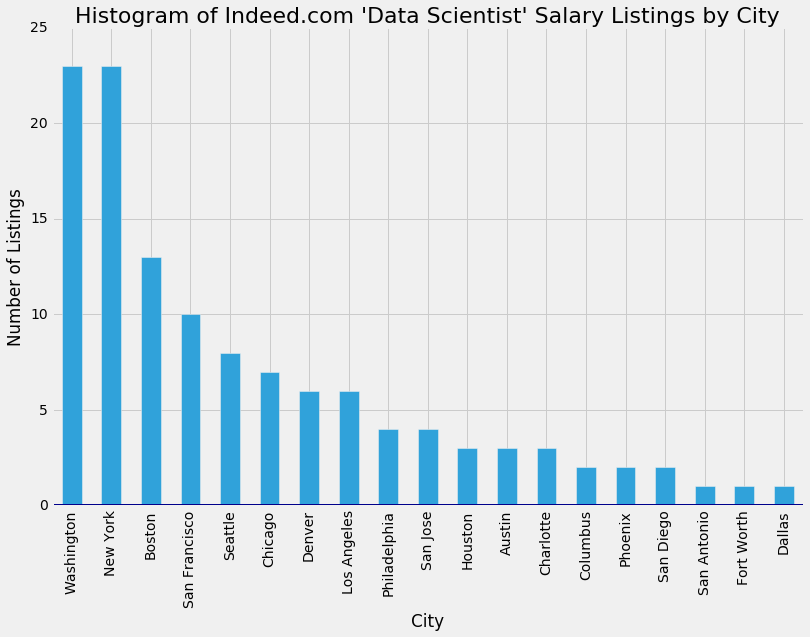

In [42]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

cities = sal_df['city'].value_counts()

cities.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Histogram of Indeed.com \'Data Scientist\' Salary Listings by City', fontsize = 22)

# y label
plt.ylabel('Number of Listings')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('City')

#plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [22]:
print 'The minimum salary listed is %s' %min(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == min(sal_df['parsed_salary'])]

The minimum salary listed is 21294.5


,title,location,company,city,state,parsed_salary
155,Data Scientist / Engineer,"San Francisco, CA",San Francisco State University,San Francisco,CA,21294.5


In [23]:
print 'The maximum salary listed is %s' %max(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == max(sal_df['parsed_salary'])]

The maximum salary listed is 250000.0


,title,location,company,city,state,parsed_salary
114,"Sr. Data Scientist, Learning Services","New York, NY 10016 (Gramercy area)",Averity,New York,NY,250000.0


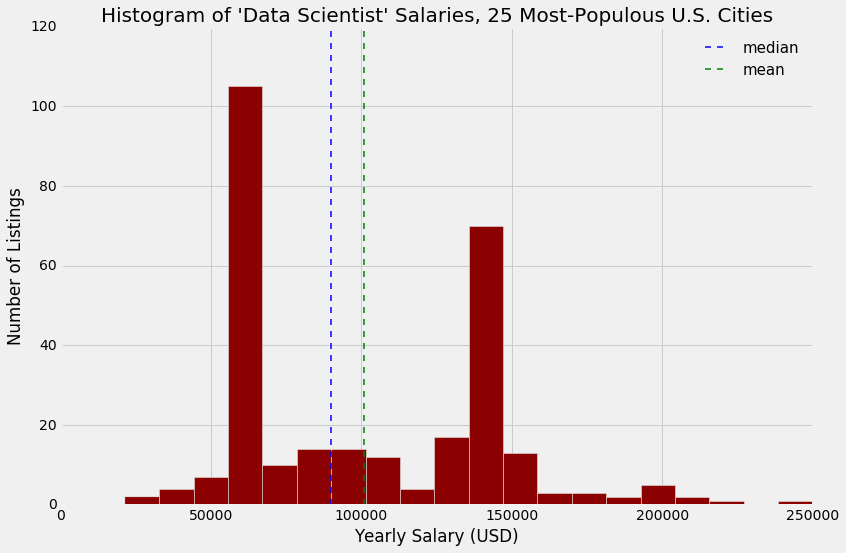

In [24]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(sal_df['parsed_salary'], color = 'darkred', bins = 20)
plt.axvline(sal_df['parsed_salary'].median(), color='b', linestyle='dashed', linewidth=1.5, label = 'median')
plt.axvline(sal_df['parsed_salary'].mean(), color='g', linestyle='dashed', linewidth=1.5, label = 'mean')

plt.title('Histogram of \'Data Scientist\' Salaries, 25 Most-Populous U.S. Cities', fontsize = 20)

# y label
plt.ylabel('Number of Listings')

# x label
plt.xlabel('Yearly Salary (USD)')

plt.xlim([0, max(sal_df['parsed_salary'])])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [44]:
median = float(sal_df['parsed_salary'].describe().loc['50%'])
print 'The median salary is %s.' %median

The median salary is 110000.0.


In [45]:
def sal_dummify(x):
    sal_dummy = []
    for i in sal_df['parsed_salary']:
        if i > median:
            sal_dummy.append(1)
        elif i <= median:
            sal_dummy.append(0)
        # This shouldn't happen, but just in case...
        else:
            sal_dummy.append('NaN')
    x['sal_dummy'] = sal_dummy
    return x

In [46]:
sal_dummify(sal_df)
sal_df['sal_dummy'].value_counts()

0    64
1    58
Name: sal_dummy, dtype: int64

In [47]:
print 'There are %s cities' %len(sal_df['city'].unique()) + ' and %s states represented in the dataframe.'\
%len(sal_df['state'].unique())
print '\n'
print 'There are %s cities' %len(df['city'].unique()) + ' and %s states represented in the original, scraped data.'\
%len(df['state'].unique())

There are 19 cities and 12 states represented in the dataframe.


There are 25 cities and 16 states represented in the original, scraped data.


In [48]:
tax_dict = {
    'TX':0,
    'CA':13.3,
    'DC':8.95,
    'NY':8.82,
    'MA':5.1,
    'IL':3.75,
    'WA':0,
    'PA':3.07,
    'AZ':4.54,
    'CO':4.63,
    'IN':3.3,
    'TN':6.0,
    'NC':5.75,
    'OH':4.997
}

In [49]:
sal_df['inc_tax_rate'] = sal_df['state'].map(tax_dict)

In [52]:
X_city = pd.DataFrame(sal_df['city'])
X_city['intercept'] = 1
X_city = pd.concat([X_city.drop('city',axis=1), pd.get_dummies(X_city['city'])], axis = 1)
y = sal_df['sal_dummy']
X_city.head(1)

,intercept,Austin,Boston,Charlotte,Chicago,Columbus,Dallas,Denver,Fort Worth,Houston,Los Angeles,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose,Seattle,Washington
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
del X_city['Austin']

In [54]:
model_city = st.MNLogit(y, X_city)
model_city_fit = model_city.fit(method = 'bfgs')
model_city_fit.summary()

         Current function value: 0.608938
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  122
Model:                        MNLogit   Df Residuals:                      103
Method:                           MLE   Df Model:                           18
Date:                Mon, 11 Jul 2016   Pseudo R-squ.:                  0.1200
Time:                        11:16:57   Log-Likelihood:                -74.290
converged:                      False   LL-Null:                       -84.416
                                        LLR p-value:                    0.3188
=================================================================================
  sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept        -0.6548      1.217     -0.538      0.591        -3.040     1.731
Boston            0.5014      1.338      0.375      0.708        -2.121     3.124
Charlotte         6.4070     10.350      0.619      0.536       -13.878    26.692
Chicago           1.0506      1.441      0.729      0.466        -1.773     3.874
Columbus         -3.8545      6.922     -0.557      0.578       -17.421     9.712
Dallas           -2.4312      5.041     -0.482      0.630       -12.312     7.450
Denver            0.2645      1.474      0.179      0.858        -2.625     3.154
Fort Worth       -2.4312      5.041     -0.482      0.630       -12.312     7.450
Houston          -4.8971      9.384     -0.522      0.602       -23.289    13.495
Los Angeles       0.8690      1.468      0.592      0.554        -2.009     3.747
New York          0.9003      1.288      0.699      0.484        -1.623     3.424
Philadelphia     -0.7296      1.744     -0.418      0.676        -4.148     2.689
Phoenix          -3.8545      6.922     -0.557      0.578       -17.421     9.712
San Antonio      -2.4312      5.041     -0.482      0.630       -12.312     7.450
San Diego         0.9423      1.877      0.502      0.616        -2.736     4.621
San Francisco     1.2216      1.384      0.883      0.377        -1.490     3.933
San Jose         -0.7296      1.744     -0.418      0.676        -4.148     2.689
Seattle           1.2238      1.422      0.860      0.390        -1.564     4.011
Washington        0.5563      1.287      0.432      0.665        -1.966     3.078
=================================================================================
"""

In [55]:
### aic and bic ###
print 'AIC: %s' %model_city_fit.aic
print 'BIC: %s' %model_city_fit.bic

AIC: 186.580779502
BIC: 239.857179352


In [64]:
lsvc = LinearSVC(C=0.121, penalty="l1", dual=False).fit(X_city, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_city)
len(sal_df[X_new == 1]['city'].unique())

19